In [1]:
import numpy as np
import pandas as pd
from pandas_datareader import data as wb
import yfinance as yf
import datetime as dt
import statsmodels as sm
from statsmodels.tools.tools import add_constant
from statsmodels.regression.linear_model import OLS
import matplotlib.pyplot as plt
import matplotlib as mpl
plt.style.use(['science','notebook','grid'])
#plt.style.available

In [2]:
# Insert Start Date Here
startdate = '2020-1-1'

# Insert Stock Tickers Here
tickers=['^BVSP','VALE3.SA','VIIA3.SA','PETR4.SA','BBDC4.SA','ITUB4.SA','MGLU3.SA','COGN3.SA','B3SA3.SA','BBAS3.SA','IRBR3.SA','ABEV3.SA','OIBR3.SA','AZUL4.SA','CIEL3.SA','PETR3.SA','JBSS3.SA','BPAC11.SA','RENT3.SA','ITSA4.SA','WEGE3.SA','LREN3.SA','SUZB3.SA','GGBR4.SA','GOLL4.SA','SBSP3.SA','BRFS3.SA','CYRE3.SA','RAIL3.SA','EQTL3.SA','RADL3.SA','MRFG3.SA','USIM5.SA','SULA11.SA','BRML3.SA','CSNA3.SA','HYPE3.SA','KLBN11.SA','PRIO3.SA','PCAR3.SA','CSAN3.SA','CVCB3.SA','CRFB3.SA','MULT3.SA','BBSE3.SA','UGPA3.SA','HAPV3.SA','TOTS3.SA','QUAL3.SA','GOAU4.SA','JHSF3.SA','CCRO3.SA','EZTC3.SA','CMIG4.SA','EMBR3.SA','SANB11.SA','YDUQ3.SA','ELET6.SA','BEEF3.SA','BRAP4.SA','MRVE3.SA','CPFE3.SA','EGIE3.SA','ENEV3.SA','BRKM5.SA','ECOR3.SA','TAEE11.SA','SAPR11.SA','MEAL3.SA','FLRY3.SA','LCAM3.SA','ALPA4.SA','GFSA3.SA','AMAR3.SA','MOVI3.SA','LIGT3.SA','ALSO3.SA','PSSA3.SA','ENBR3.SA','EVEN3.SA','TEND3.SA','MDIA3.SA','VIVA3.SA','BIDI11.SA','RAPT4.SA','TRPL4.SA','POMO4.SA','BRSR6.SA','SMTO3.SA','ARZZ3.SA','MYPK3.SA','BRPR3.SA','SLCE3.SA','TCSA3.SA','TRIS3.SA','DIRR3.SA','GUAR3.SA','POSI3.SA','CMIG3.SA','SQIA3.SA','CPLE6.SA','ENGI11.SA','NTCO3.SA','ALUP11.SA','VIVT3.SA','ANIM3.SA','BKBR3.SA','BMGB4.SA','CAML3.SA','CEAB3.SA','CSMG3.SA','DMMO3.SA','ENAT3.SA','GRND3.SA','HBOR3.SA','LEVE3.SA','LJQQ3.SA','LOGG3.SA','LOGN3.SA','LPSB3.SA','LWSA3.SA','MILS3.SA','MTRE3.SA','ODPV3.SA','PARD3.SA','PTBL3.SA','RCSL4.SA','ROMI3.SA','UNIP6.SA','WIZS3.SA','SIMH3.SA','SEER3.SA','TASA4.SA','TGMA3.SA','DMVF3.SA','AALR3.SA','PRNR3.SA','APER3.SA','FRAS3.SA']

In [3]:
#Functions

def ATR(DF,n):
    "function to calculate True Range and Average True Range"
    df = DF.copy()
    df['H-L']=abs(df['High']-df['Low'])
    df['H-PC']=abs(df['High']-df['Adj Close'].shift(1))
    df['L-PC']=abs(df['Low']-df['Adj Close'].shift(1))
    df['TR']=df[['H-L','H-PC','L-PC']].max(axis=1,skipna=False)
    df['ATR'] = df['TR'].rolling(n).mean()
    #df['ATR'] = df['TR'].ewm(span=n,adjust=False,min_periods=n).mean()
    df2 = df.drop(['H-L','H-PC','L-PC'],axis=1)
    return df2


def ADX(DF,n):
    "function to calculate ADX"
    df2 = DF.copy()
    df2['TR'] = ATR(df2,n)['TR'] #the period parameter of ATR function does not matter because period does not influence TR calculation
    df2['DMplus']=np.where((df2['High']-df2['High'].shift(1))>(df2['Low'].shift(1)-df2['Low']),df2['High']-df2['High'].shift(1),0)
    df2['DMplus']=np.where(df2['DMplus']<0,0,df2['DMplus'])
    df2['DMminus']=np.where((df2['Low'].shift(1)-df2['Low'])>(df2['High']-df2['High'].shift(1)),df2['Low'].shift(1)-df2['Low'],0)
    df2['DMminus']=np.where(df2['DMminus']<0,0,df2['DMminus'])
    TRn = []
    DMplusN = []
    DMminusN = []
    TR = df2['TR'].tolist()
    DMplus = df2['DMplus'].tolist()
    DMminus = df2['DMminus'].tolist()
    for i in range(len(df2)):
        if i < n:
            TRn.append(np.NaN)
            DMplusN.append(np.NaN)
            DMminusN.append(np.NaN)
        elif i == n:
            TRn.append(df2['TR'].rolling(n).sum().tolist()[n])
            DMplusN.append(df2['DMplus'].rolling(n).sum().tolist()[n])
            DMminusN.append(df2['DMminus'].rolling(n).sum().tolist()[n])
        elif i > n:
            TRn.append(TRn[i-1] - (TRn[i-1]/n) + TR[i])
            DMplusN.append(DMplusN[i-1] - (DMplusN[i-1]/n) + DMplus[i])
            DMminusN.append(DMminusN[i-1] - (DMminusN[i-1]/n) + DMminus[i])
    df2['TRn'] = np.array(TRn)
    df2['DMplusN'] = np.array(DMplusN)
    df2['DMminusN'] = np.array(DMminusN)
    df2['DIplusN']=100*(df2['DMplusN']/df2['TRn'])
    df2['DIminusN']=100*(df2['DMminusN']/df2['TRn'])
    df2['DIdiff']=abs(df2['DIplusN']-df2['DIminusN'])
    df2['DIsum']=df2['DIplusN']+df2['DIminusN']
    df2['DX']=100*(df2['DIdiff']/df2['DIsum'])
    ADX = []
    DX = df2['DX'].tolist()
    for j in range(len(df2)):
        if j < 2*n-1:
            ADX.append(np.NaN)
        elif j == 2*n-1:
            ADX.append(df2['DX'][j-n+1:j+1].mean())
        elif j > 2*n-1:
            ADX.append(((n-1)*ADX[j-1] + DX[j])/n)
    df2['ADX']=np.array(ADX)
    return df2['ADX']

def rsi(df, n):
    "function to calculate RSI"
    delta = df["Adj Close"].diff().dropna()
    u = delta * 0
    d = u.copy()
    u[delta > 0] = delta[delta > 0]
    d[delta < 0] = -delta[delta < 0]
    u[u.index[n-1]] = np.mean( u[:n]) # first value is average of gains
    u = u.drop(u.index[:(n-1)])
    d[d.index[n-1]] = np.mean( d[:n]) # first value is average of losses
    d = d.drop(d.index[:(n-1)])
    rs = u.ewm(com=n,min_periods=n).mean()/d.ewm(com=n,min_periods=n).mean()
    return 100 - 100 / (1+rs)

def MACD(DF,a,b,c):
    """function to calculate MACD
       typical values a = 12; b =26, c =9"""
    df = DF.copy()
    df["MA_Fast"]=df["Adj Close"].ewm(span=a,min_periods=a).mean()
    df["MA_Slow"]=df["Adj Close"].ewm(span=b,min_periods=b).mean()
    df["MACD"]=df["MA_Fast"]-df["MA_Slow"]
    df["Signal"]=df["MACD"].ewm(span=c,min_periods=c).mean()
    df.dropna(inplace=True)
    return df


def slope(ser,n):
    "function to calculate the slope of regression line for n consecutive points on a plot"
    ser = (ser - ser.min())/(ser.max() - ser.min())
    x = np.array(range(len(ser)))
    x = (x - x.min())/(x.max() - x.min())
    slopes = [i*0 for i in range(n-1)]
    for i in range(n,len(ser)+1):
        y_scaled = ser[i-n:i]
        x_scaled = x[:n]
        x_scaled = add_constant(x_scaled)
        model = OLS(y_scaled,x_scaled)
        results = model.fit()
        slopes.append(results.params[-1])
    slope_angle = (np.rad2deg(np.arctan(np.array(slopes))))
    return np.array(slope_angle)


In [4]:
%%time

sec_data_final = pd.DataFrame()

len_tickers = len(tickers)
estimated_time = len(tickers)*10/60

fails = 0
success = 0
fail_list = []

print("Estimated Time: {:.0f} minutes for {} tickers".format(estimated_time, len_tickers))
print("+++ Data Load Started +++")

for t in tickers: 
    try:
            sec_data = pd.DataFrame()
            sec_data = wb.DataReader(t, data_source='yahoo', start = startdate)#,session=session)
            sec_data.reset_index(level=0, inplace=True)
            
            sec_data['LastPrice'] = sec_data['Adj Close'].shift(1)
            
            sec_data['PctReturn'] = ( sec_data['Adj Close']/sec_data['LastPrice'] )-1
            
            sec_data['LogReturn'] = np.log(sec_data['Adj Close'] / sec_data['Adj Close'].shift(1))
            
            sec_data['Body'] = abs(sec_data['Adj Close']-sec_data['Open'])
            sec_data['Shadow_Lower'] = np.where(sec_data['Adj Close']>=sec_data['Open'],sec_data['Open']-sec_data['Low'],sec_data['Adj Close']-sec_data['Low'] )
            sec_data['Shadow_Upper'] = np.where(sec_data['Adj Close']>=sec_data['Open'],sec_data['High']-sec_data['Adj Close'],sec_data['High']-sec_data['Open'] )
            
            sec_data['Body_Relative'] = (abs(sec_data['Adj Close']-sec_data['Open'])/(abs(sec_data['Adj Close']+sec_data['Open'])/2))
            
            sec_data['Shadow_Lower_Relative'] = sec_data['Shadow_Lower']/sec_data['Body']
            sec_data['Shadow_Upper_Relative'] = sec_data['Shadow_Upper']/sec_data['Body']
            sec_data['Volatility_Anual'] = sec_data['LogReturn'].rolling(window=252).std()*np.sqrt(252)
            sec_data['Volatility_Month'] = sec_data['LogReturn'].rolling(window=21).std()*np.sqrt(252)      
            
            sec_data['Last_Returns_10'] = sec_data['LogReturn'].rolling(window=10).sum()
                        
            sec_data['Trend5'] = slope(sec_data['Adj Close'],5)
            sec_data['Trend9'] = slope(sec_data['Adj Close'],9)
            sec_data['Trend14'] = slope(sec_data['Adj Close'],14)
            sec_data['Trend20'] = slope(sec_data['Adj Close'],20)
            
            sec_data['Momentum_10'] = sec_data['Adj Close']-sec_data['Adj Close'].shift(9)  
            sec_data['Momentum_10_SMA_9'] = sec_data['Momentum_10'].rolling(window=9).mean()
            
            sec_data['OBVsign'] = np.where(sec_data['Adj Close']<sec_data['LastPrice'],-1,1)*sec_data['Volume']
            sec_data['OBV'] = sec_data['OBVsign'].cumsum()
            
            sec_data['OBV_Trend5'] = slope(sec_data['OBV'],5)
            sec_data['OBV_Trend14'] = slope(sec_data['OBV'],14)
            
            sec_data['ADX14'] = ADX(sec_data,14) 
            sec_data['ADX14_Trend5'] = slope(sec_data['ADX14'],5)
            sec_data['ADX14_Trend14'] = slope(sec_data['ADX14'],14)
            
            sec_data['ATR14'] = ATR(sec_data,14)['ATR']
            sec_data['ATR14_Trend5'] = slope(sec_data['ATR14'],5)
            sec_data['ATR14_Trend14'] = slope(sec_data['ATR14'],14)      
            
             
            sec_data['SMA3'] = sec_data['Adj Close'].rolling(window=3).mean()                            
            sec_data['SMA8'] = sec_data['Adj Close'].rolling(window=8).mean()
            sec_data['SMA20'] = sec_data['Adj Close'].rolling(window=20).mean()
            sec_data['SMA20_STD'] = sec_data['Adj Close'].rolling(window=20).std()
            sec_data['SMA200'] = sec_data['Adj Close'].rolling(window=200).mean()            
                     
            sec_data['Bollinger_Sup'] = sec_data['SMA20']+2*sec_data['SMA20_STD']
            sec_data['Bollinger_Inf'] = sec_data['SMA20']-2*sec_data['SMA20_STD']
            
            sec_data['Bollinger_Sup%'] = (sec_data['Adj Close']-sec_data['Bollinger_Sup'])/sec_data['Adj Close']
            sec_data['Bollinger_Inf%'] = (sec_data['Adj Close']-sec_data['Bollinger_Inf'])/sec_data['Adj Close']
            
            sec_data['Bollinger_Spread'] = (sec_data['Bollinger_Sup']-sec_data['Bollinger_Inf'])/sec_data['SMA20']
            sec_data['Bollinger_Spread_Trend5'] = slope(sec_data['Bollinger_Spread'],5)
            sec_data['Bollinger_Spread_Trend14'] = slope(sec_data['Bollinger_Spread'],14)
            
            sec_data['IFR_2'] = rsi(sec_data,2)
            sec_data['IFR'] = rsi(sec_data,9)
            
            sec_data['IFR_Trend5'] = slope(sec_data['IFR'],5)
            sec_data['IFR_Trend14'] = slope(sec_data['IFR'],14)
            
            sec_data['EMA9'] = sec_data['Adj Close'].ewm(span=9,adjust=False).mean()
            sec_data['EMA9%'] = (sec_data['Adj Close']-sec_data['EMA9'])/sec_data['Adj Close']
            
            sec_data['EMA9_Trend9'] = slope(sec_data['EMA9'],9)
            
            sec_data['EMA12'] = sec_data['Adj Close'].ewm(span=12,adjust=False).mean()
            sec_data['EMA21'] = sec_data['Adj Close'].ewm(span=21,adjust=False).mean()
            sec_data['EMA21%'] = (sec_data['Adj Close']-sec_data['EMA21'])/sec_data['Adj Close']
            sec_data['EMA26'] = sec_data['Adj Close'].ewm(span=26,adjust=False).mean()
            
            sec_data['EMA50'] = sec_data['Adj Close'].ewm(span=50,adjust=False).mean()
            sec_data['EMA50%'] = (sec_data['Adj Close']-sec_data['EMA50'])/sec_data['Adj Close']
            
            sec_data['EMA50_Trend14'] = slope(sec_data['EMA50'],14)
                        
            sec_data['EMA200'] = sec_data['Adj Close'].ewm(span=200,adjust=False).mean()
            sec_data['EMA200%'] = (sec_data['Adj Close']-sec_data['EMA200'])/sec_data['Adj Close']
            
            sec_data['MACD'] = sec_data['EMA12']-sec_data['EMA26']
            sec_data['MACD_Signal'] =  sec_data['MACD'].ewm(span=9,adjust=False).mean()
            sec_data['MACD_Hist'] = sec_data['MACD'] - sec_data['MACD_Signal']          
            
            sec_data['MACD_Hist_Trend5'] = slope(sec_data['MACD_Hist'],5)
            sec_data['MACD_Hist_Trend14'] = slope(sec_data['MACD_Hist'],14)
                       
            sec_data['SMA9_VOLUME'] = sec_data['Volume'].rolling(window=9).mean()
            sec_data['SMA20_VOLUME'] = sec_data['Volume'].rolling(window=20).mean()
            sec_data['SMA200_VOLUME'] = sec_data['Volume'].rolling(window=200).mean()
            
            sec_data['SMA9_VOLUME%'] = (sec_data['Volume']/sec_data['SMA9_VOLUME']) - 1
            sec_data['SMA20_VOLUME%'] = (sec_data['Volume']/sec_data['SMA20_VOLUME']) - 1
            
            sec_data['STOCHASTIC_K_FAST'] = 100 * (sec_data['Adj Close'] - sec_data['Low'].rolling( window = 14 ).min())/(sec_data['High'].rolling( window = 14 ).max() - sec_data['Low'].rolling( window = 14 ).min())
            sec_data['STOCHASTIC_D_FAST'] = sec_data['STOCHASTIC_K_FAST'].rolling(window = 3).mean()
            
            sec_data['STOCHASTIC_K_SLOW'] = sec_data['STOCHASTIC_D_FAST']
            sec_data['STOCHASTIC_D_SLOW'] = sec_data['STOCHASTIC_K_SLOW'].rolling(window = 3).mean()
            
            sec_data['STO_Trend5'] = slope(sec_data['STOCHASTIC_D_SLOW'],5)
            sec_data['STO_Trend14'] = slope(sec_data['STOCHASTIC_D_SLOW'],14)
            
            #### SETUPS ###############################################################################
            
            sec_data['#Romp_EMA9_Bear'] = np.where((sec_data['EMA9_Trend9']>2) & (sec_data['Adj Close']<sec_data['EMA9']),1,0)
            sec_data['#Romp_EMA9_Bull'] = np.where((sec_data['EMA9_Trend9']<-2) & (sec_data['Adj Close']>sec_data['EMA9']),1,0)
            sec_data['#Romp_EMA9'] = sec_data['#Romp_EMA9_Bear'] + sec_data['#Romp_EMA9_Bull']
            
            sec_data['#Romp_EMA50_Bear'] = np.where((sec_data['EMA50_Trend14']>2) & (sec_data['Adj Close']<sec_data['EMA50']),1,0)
            sec_data['#Romp_EMA50_Bull'] = np.where((sec_data['EMA50_Trend14']<-2) & (sec_data['Adj Close']>sec_data['EMA50']),1,0)
            sec_data['#Romp_EMA50'] = sec_data['#Romp_EMA50_Bear'] + sec_data['#Romp_EMA50_Bull']
            
            sec_data['#MACDH_Change_Bear'] = np.where((sec_data['MACD_Hist'].shift(1)>0)&(sec_data['MACD_Hist']<0),-1,0)
            sec_data['#MACDH_Change_Bull'] = np.where((sec_data['MACD_Hist'].shift(1)<0)&(sec_data['MACD_Hist']>0),1,0) 
            sec_data['#MACDH_Change'] =  sec_data['#MACDH_Change_Bear'] + sec_data['#MACDH_Change_Bull']
            
            sec_data['#EMA9_Change_Bear'] = np.where((sec_data['EMA9_Trend9']>0)&(sec_data['EMA9']<sec_data['EMA9'].shift(1)),-1,0)
            sec_data['#EMA9_Change_Bull'] = np.where((sec_data['EMA9_Trend9']<0)&(sec_data['EMA9']>sec_data['EMA9'].shift(1)),1,0)
            sec_data['#EMA9_Change'] = sec_data['#EMA9_Change_Bear'] + sec_data['#EMA9_Change_Bull']
            
            sec_data['#Trend_Divergence_Bear'] =  np.where((sec_data['Trend5']>0) & (sec_data['IFR_Trend5']<0) & (sec_data['OBV_Trend5']<0),-1,0)
            sec_data['#Trend_Divergence_Bull'] =  np.where((sec_data['Trend5']<0)& (sec_data['IFR_Trend5']>0) & (sec_data['OBV_Trend5']>0),1,0)
            sec_data['#Trend_Divergence'] = sec_data['#Trend_Divergence_Bear']+sec_data['#Trend_Divergence_Bull']
            
            sec_data['#IFR2_Bear'] = np.where((sec_data['EMA9_Trend9']<-2)&(sec_data['IFR_2']>90),1,0)
            sec_data['#IFR2_Bull'] = np.where((sec_data['EMA9_Trend9']>2)&(sec_data['IFR_2']<10),1,0)
            sec_data['#IFR2'] = sec_data['#IFR2_Bear'] + sec_data['#IFR2_Bull']
            
            sec_data['#AGULHADA'] = np.where( 
                (sec_data['SMA3']>sec_data['SMA8']) & 
                (sec_data['SMA8']>sec_data['SMA20']) & 
                (sec_data['SMA20'].shift(2) > sec_data['SMA8'].shift(2)) &
                (sec_data['SMA8'].shift(2) > sec_data['SMA3'].shift(2)),1,0)
            
            sec_data['#INSIDEBAR_Bull'] = np.where(
                (sec_data['Adj Close']<sec_data['Adj Close'].shift(1))&
                (sec_data['Adj Close']>sec_data['Open'].shift(1))&
                (sec_data['High']<sec_data['High'].shift(1))&
                (sec_data['Low']>sec_data['Low'].shift(1))&
                (sec_data['Open']>sec_data['Open'].shift(1))&
                (sec_data['Open']<sec_data['Adj Close'].shift(1)),1,0)
            
            sec_data['#INSIDEBAR_Bear'] = np.where(
                (sec_data['Adj Close']>sec_data['Adj Close'].shift(1))&
                (sec_data['Adj Close']<sec_data['Open'].shift(1))&
                (sec_data['High']<sec_data['High'].shift(1))&
                (sec_data['Low']>sec_data['Low'].shift(1))&
                (sec_data['Open']<sec_data['Open'].shift(1))&
                (sec_data['Open']>sec_data['Adj Close'].shift(1)),1,0)
            
            sec_data['#INSIDEBAR'] = sec_data['#INSIDEBAR_Bull'] + sec_data['#INSIDEBAR_Bear']
                        
            sec_data['Stock'] = t[:-3]
            
            sec_data_final = pd.concat([sec_data_final,sec_data])
            
            ##############################################################################
            
            success = success + 1
            left_to_load = len_tickers - success - fails
            time_left = left_to_load*10/60
            completion = (fails+success)/len(tickers)
            
            print('+++ Data Load Complete for {}___{:.2%}____{:.1f} minutes left'.format(t,completion,time_left))      
          
    except Exception as e: 
            fails = fails + 1
            fail_list.append(t)
            print("--- ", e)

    
print('\nSuccessful Loads: {}  Failed: {}'.format(success,fails))
print("List of Fails:", fail_list)  


Estimated Time: 23 minutes for 139 tickers
+++ Data Load Started +++
+++ Data Load Complete for ^BVSP___0.72%____23.0 minutes left
+++ Data Load Complete for VALE3.SA___1.44%____22.8 minutes left
+++ Data Load Complete for VIIA3.SA___2.16%____22.7 minutes left
+++ Data Load Complete for PETR4.SA___2.88%____22.5 minutes left
+++ Data Load Complete for BBDC4.SA___3.60%____22.3 minutes left
+++ Data Load Complete for ITUB4.SA___4.32%____22.2 minutes left
+++ Data Load Complete for MGLU3.SA___5.04%____22.0 minutes left
+++ Data Load Complete for COGN3.SA___5.76%____21.8 minutes left
+++ Data Load Complete for B3SA3.SA___6.47%____21.7 minutes left
+++ Data Load Complete for BBAS3.SA___7.19%____21.5 minutes left
+++ Data Load Complete for IRBR3.SA___7.91%____21.3 minutes left
+++ Data Load Complete for ABEV3.SA___8.63%____21.2 minutes left
+++ Data Load Complete for OIBR3.SA___9.35%____21.0 minutes left
+++ Data Load Complete for AZUL4.SA___10.07%____20.8 minutes left
+++ Data Load Complete 

+++ Data Load Complete for PARD3.SA___89.93%____2.3 minutes left
+++ Data Load Complete for PTBL3.SA___90.65%____2.2 minutes left
+++ Data Load Complete for RCSL4.SA___91.37%____2.0 minutes left
+++ Data Load Complete for ROMI3.SA___92.09%____1.8 minutes left
+++ Data Load Complete for UNIP6.SA___92.81%____1.7 minutes left
+++ Data Load Complete for WIZS3.SA___93.53%____1.5 minutes left
+++ Data Load Complete for SIMH3.SA___94.24%____1.3 minutes left
+++ Data Load Complete for SEER3.SA___94.96%____1.2 minutes left
+++ Data Load Complete for TASA4.SA___95.68%____1.0 minutes left
+++ Data Load Complete for TGMA3.SA___96.40%____0.8 minutes left
+++ Data Load Complete for DMVF3.SA___97.12%____0.7 minutes left
+++ Data Load Complete for AALR3.SA___97.84%____0.5 minutes left
+++ Data Load Complete for PRNR3.SA___98.56%____0.3 minutes left
+++ Data Load Complete for APER3.SA___99.28%____0.2 minutes left
+++ Data Load Complete for FRAS3.SA___100.00%____0.0 minutes left

Successful Loads: 139  

In [5]:
pd.set_option('display.max_columns', None)
#sec_data_final

last_date = sec_data_final[['Date']].max()

sec_last_date = sec_data_final[(sec_data_final['Date'] == sec_data_final['Date'].max())]

sec_last_date.to_csv('bovespa_diario_last_date.csv', sep =';', index=False)

sec_last_date

,Date,High,Low,Open,Close,Volume,Adj Close,LastPrice,PctReturn,LogReturn,Body,Shadow_Lower,Shadow_Upper,Body_Relative,Shadow_Lower_Relative,Shadow_Upper_Relative,Volatility_Anual,Volatility_Month,Last_Returns_10,Trend5,Trend9,Trend14,Trend20,Momentum_10,Momentum_10_SMA_9,OBVsign,OBV,OBV_Trend5,OBV_Trend14,ADX14,ADX14_Trend5,ADX14_Trend14,ATR14,ATR14_Trend5,ATR14_Trend14,SMA3,SMA8,SMA20,SMA20_STD,SMA200,Bollinger_Sup,Bollinger_Inf,Bollinger_Sup%,Bollinger_Inf%,Bollinger_Spread,Bollinger_Spread_Trend5,Bollinger_Spread_Trend14,IFR_2,IFR,IFR_Trend5,IFR_Trend14,EMA9,EMA9%,EMA9_Trend9,EMA12,EMA21,EMA21%,EMA26,EMA50,EMA50%,EMA50_Trend14,EMA200,EMA200%,MACD,MACD_Signal,MACD_Hist,MACD_Hist_Trend5,MACD_Hist_Trend14,SMA9_VOLUME,SMA20_VOLUME,SMA200_VOLUME,SMA9_VOLUME%,SMA20_VOLUME%,STOCHASTIC_K_FAST,STOCHASTIC_D_FAST,STOCHASTIC_K_SLOW,STOCHASTIC_D_SLOW,STO_Trend5,STO_Trend14,#Romp_EMA9_Bear,#Romp_EMA9_Bull,#Romp_EMA9,#Romp_EMA50_Bear,#Romp_EMA50_Bull,#Romp_EMA50,#MACDH_Change_Bear,#MACDH_Change_Bull,#MACDH_Change,#EMA9_Change_Bear,#EMA9_Change_Bull,#EMA9_Change,#Trend_Divergence_Bear,#Trend_Divergence_Bull,#Trend_Divergence,#IFR2_Bear,#IFR2_Bull,#IFR2,#AGULHADA,#INSIDEBAR_Bull,#INSIDEBAR_Bear,#INSIDEBAR,Stock
578,2022-05-04,108382.000000,104933.000000,106529.000000,108344.000000,0.0,108344.000000,106528.00,0.017047,0.016903,1815.000000,1596.000000,38.000000,0.016894,0.879339,0.020937,0.195180,0.175643,-0.060116,-75.506308,-76.022643,-82.019603,-80.838554,-6000.000000,-7745.000000,0.0,1.509900e+08,-86.204751,-83.570906,30.260687,84.253630,85.983053,2079.428571,78.387769,73.778258,107170.333333,108444.125000,113204.000000,4425.461582,112399.780000,122054.923163,104353.076837,-0.126550,0.036836,0.156371,73.213062,82.432321,55.872957,34.189914,78.531693,-85.272594,109224.261765,-0.008125,-82.608369,110107.897064,111935.657999,-0.033151,112487.940539,113083.111084,-0.043741,-65.000244,112642.359877,-0.039673,-2380.043475,-1559.531514,-820.511962,80.576870,-76.125399,1.021128e+07,10120010.0,11005377.00,-1.000000,-1.000000,27.516941,15.967367,15.967367,10.679818,67.118605,-52.352488,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,^B
578,2022-05-04,82.180000,79.849998,81.930000,81.809998,34032200.0,81.809998,82.50,-0.008364,-0.008399,0.120003,1.959999,0.250000,0.001466,16.332952,2.083286,0.361928,0.359890,-0.069294,-76.796254,73.611013,-80.561041,-82.225127,-3.590004,-10.485557,-34032200.0,5.818723e+08,-86.159705,-82.222797,20.238897,-65.497084,85.938306,3.117856,28.203595,69.581836,82.409999,81.746249,87.743500,6.417759,82.817363,100.579018,74.907982,-0.229422,0.084366,0.292569,2.695005,88.163189,33.177832,34.341991,-83.374593,43.169881,83.304117,-0.018263,-78.056955,84.196023,86.507210,-0.057416,87.326590,88.245240,-0.078661,-69.106371,83.690616,-0.022988,-3.130567,-2.645079,-0.485488,88.357546,62.223658,4.009728e+07,30854135.0,27893164.00,-0.151259,0.103003,25.356280,27.526059,27.526059,28.947843,81.491558,57.328248,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,VALE3
578,2022-05-04,3.070000,2.750000,2.830000,3.020000,53052600.0,3.020000,2.86,0.055944,0.054435,0.190000,0.080000,0.050000,0.064957,0.421052,0.263158,0.578252,0.486069,-0.121455,-35.803814,-43.883456,-55.889706,-60.039458,-0.250000,-0.478889,53052600.0,4.256627e+08,-79.424745,-58.647996,30.074456,86.249347,85.063779,0.177143,-57.631582,-56.802102,2.930000,3.018750,3.338500,0.339772,6.555750,4.018044,2.658956,-0.330478,0.119551,0.407095,-79.689415,78.161758,59.097608,35.396861,83.697609,-79.131898,3.062590,-0.014103,-58.704887,3.127470,3.285845,-0.088028,3.351557,3.617763,-0.197935,-46.142224,6.336909,-1.098314,-0.224087,-0.187057,-0.037030,63.937987,24.105280,5.089823e+07,54875085.0,47037404.00,0.042327,-0.033212,31.764707,13.952622,13.952622,7.232990,49.679605,-60.691383,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,VIIA3
578,2022-05-04,32.169998,30.400000,30.600000,32.070000,109417000.0,32.070000,30.25,0.060165,0.058425,1.469999,0.200001,0.099998,0.046912,0.136055,0.068026,0.347915,0.3532

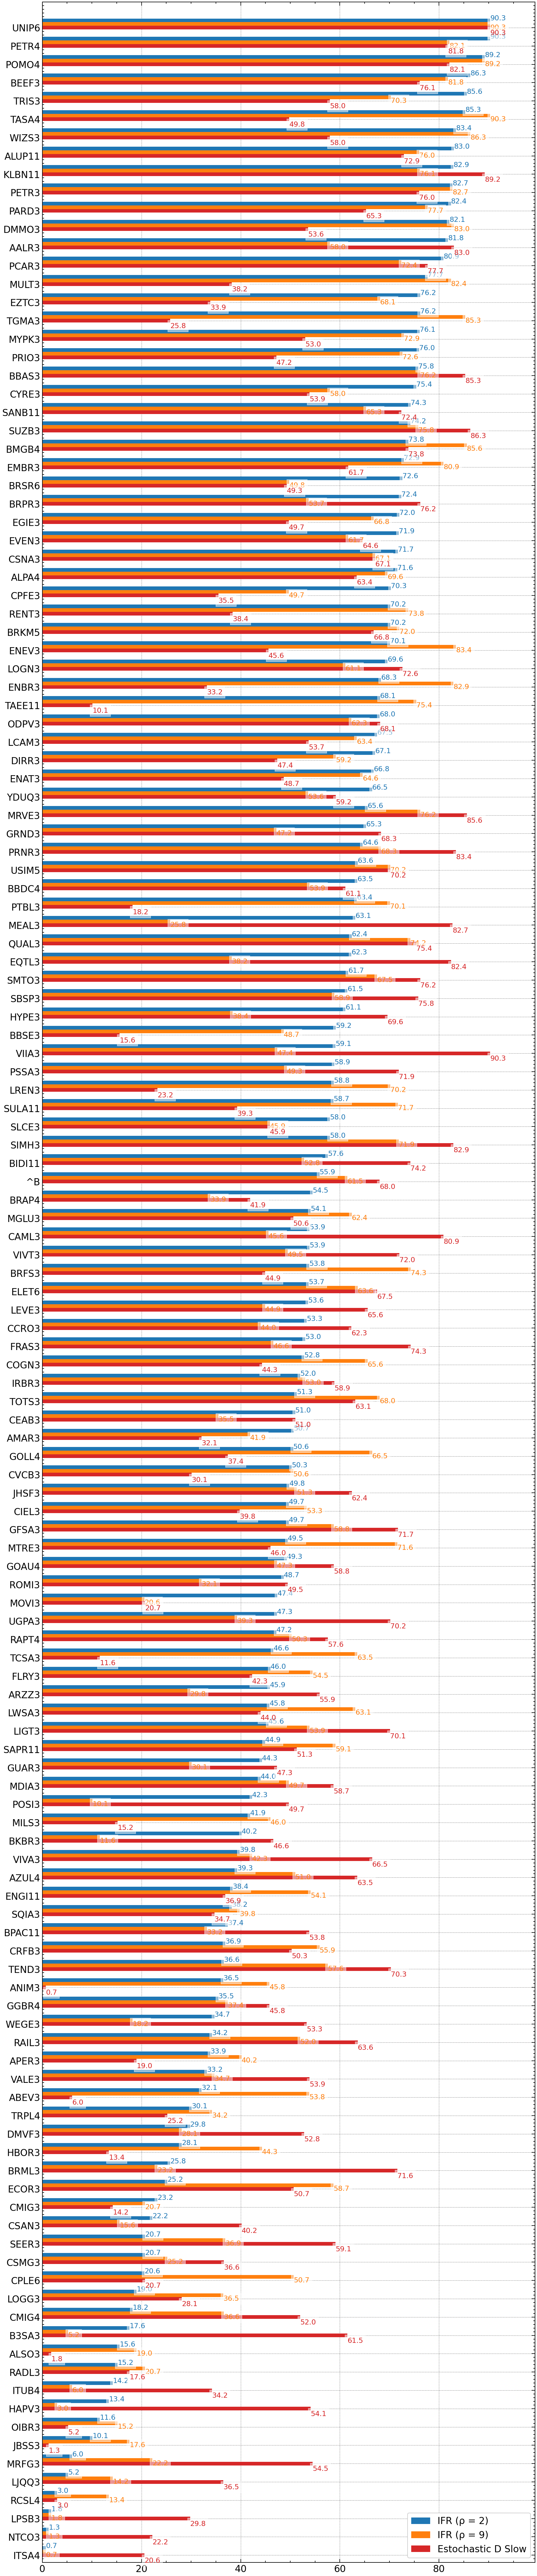

In [6]:
fig, ax = plt.subplots(1,1, figsize=(15,80), dpi=150)
y = sec_last_date.sort_values(by=['IFR_2'],ascending = True)['Stock']
x1 = sec_last_date.sort_values(by=['IFR_2'],ascending = True)['IFR_2'].round(1)
x2 = sec_last_date.sort_values(by=['IFR'],ascending = True)['IFR_2'].round(1)
x3 = sec_last_date.sort_values(by=['STOCHASTIC_D_SLOW'],ascending = True)['IFR_2'].round(1)

ind   = np.arange(len(y))
width = 0.2

ax.barh(ind, x1, width, color='tab:blue',align='center', label='IFR (\u03C1 = 2)')
ax.barh(ind - width, x2, width, color='tab:orange',align='center', label='IFR (\u03C1 = 9)')
ax.barh(ind - 2*width, x3, width, color='tab:red',align='center', label='Estochastic D Slow')

ax.set(yticks = ind - 2*width, yticklabels = y, ylim=[width - 1, len(y)], xlim = [0, sec_last_date.IFR_2.max()*1.1])

ax.legend()

for i, v in enumerate(x1):
    t =  ax.text(v, i, str(v), fontsize = 12, color='tab:blue')
    t.set_bbox(dict(facecolor='white', alpha=0.5, edgecolor='white'))

for i, v in enumerate(x2):
    t=ax.text(v, i-0.5, str(v), fontsize = 12, color='tab:orange')
    t.set_bbox(dict(facecolor='white', alpha=0.5, edgecolor='white'))
    
for i, v in enumerate(x3):
    t=ax.text(v, i-0.8, str(v), fontsize = 12, color='tab:red')
    t.set_bbox(dict(facecolor='white', alpha=0.5, edgecolor='white'))
    
plt.show()